# Assignment: Build an AI Agentic System using CrewAI and Langfuse

In this assignment, you will choose one use case from the list below to build a multi-agent AI system using **CrewAI** for orchestration and **Langfuse** for observability.

You are free to explore and expand your chosen use case as long as it fits within the multi-agent framework.

## Use Case Options
Choose **one** of the following:

1. **Job Application Advisor**  
   - Agents analyze job descriptions, tailor resumes, and generate cover letters.

2. **Startup Pitch Evaluator**  
   - Agents assess startup ideas, check market trends, and generate investor feedback.

3. **Healthcare Appointment Assistant**  
   - Agents take symptoms as input, find suitable doctors, and book appointments.

4. **Educational Course Recommender**  
   - Agents evaluate user interests and recommend relevant learning paths.

5. **AI-Powered Travel Planner**  
   - Agents recommend destinations, generate itineraries, and check weather data.


## Setup Instructions

Before starting, install the required packages.

In [ ]:
!pip install crewai langfuse openai langchain-groq openlit typing

In [ ]:
import os
from crewai import Agent, Task, Crew, Process
from langchain_core.tools import Tool
from langchain_groq import ChatGroq
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler
from google.colab import userdata
from langchain.tools import tool
from pydantic import BaseModel, Field
langfuse = Langfuse(
    public_key=userdata.get('langfuse_public'),
    secret_key=userdata.get('langfuse_secret'),
    host="https://cloud.langfuse.com"
)
import base64
LANGFUSE_AUTH=base64.b64encode(f"{userdata.get('langfuse_public')}:{userdata.get('langfuse_secret')}".encode()).decode()
os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "https://cloud.langfuse.com/api/public/otel" # EU data region
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"
langfuse_handler = CallbackHandler()
from langchain.tools import StructuredTool
from crewai.tools import BaseTool
from typing import Type

Define Functions For Tools

In [ ]:
# --------------------------- Tool: Read Text File ---------------------------
class ReadTextFileInput(BaseModel):
    file_path: str = Field(..., description="Path to the local text file to read")


class ReadTextFileTool(BaseTool):
    name: str = "Read Text File"
    description: str = "Reads the contents of a specified local text file."
    args_schema: Type[BaseModel] = ReadTextFileInput

    def _run(self, file_path: str) -> str:
        try:
            with open(file_path, 'r') as file:
                return file.read()
        except Exception as e:
            return f"Error reading file: {str(e)}"


# --------------------------- Tool: Get Webpage Contents (Dummy) ---------------------------
class GetWebpageContentsInput(BaseModel):
    url: str = Field(..., description="The URL to fetch (ignored in dummy, but required)")


class GetWebpageContentsTool(BaseTool):
    name: str = "Get Webpage Contents"
    description: str = "Returns the contents of a local announcements.txt file, simulating a URL fetch."
    args_schema: Type[BaseModel] = GetWebpageContentsInput

    def _run(self, url: str) -> str:
        print(f"Dummy get_webpage_contents called for URL: {url} (returning local announcements.txt)")
        try:
            with open("announcements.txt", "r", encoding="utf-8") as f:
                return f.read()
        except FileNotFoundError:
            return "No announcements found. (announcements.txt file is missing)"


# --------------------------- Tool: Mock Search for Job URL ---------------------------
class MockSearchForJobUrlInput(BaseModel):
    query: str = Field(..., description="Search query string to find the job URL")


class MockSearchForJobUrlTool(BaseTool):
    name: str = "Mock Search for Job URL"
    description: str = "Returns a mock job URL based on query keywords."
    args_schema: Type[BaseModel] = MockSearchForJobUrlInput

    def _run(self, query: str) -> str:
        print(f"DEBUG: Mock search tool called for query: {query}")
        q = query.lower()
        if "ai engineer" in q or "stellar innovations" in q:
            return "https://stellarinnovations.com/careers/ai_engineer_job_id_123"
        elif "data scientist" in q:
            return "https://datasciencemockjobs.com/job_id_456"
        else:
            return "https://genericjobs.com/listing_000"

Define Agents

In [ ]:
def create_job_posting_searcher_agent(llm_model) -> Agent:
    return Agent(
        role='Job Posting URL Searcher',
        goal='Find the direct URL for a specific job posting based on keywords',
        backstory="...",
        verbose=True,
        tools=[MockSearchForJobUrlTool()],
        allow_delegation=False,
        llm=llm_model
    )

def create_job_description_crawler_agent(llm_model) -> Agent:
    return Agent(
        role='Job Description Crawler',
        goal='Extract and analyze key information from a job posting URL',
        backstory="...",
        verbose=True,
        tools=[GetWebpageContentsTool()],
        allow_delegation=False,
        llm=llm_model
    )

def create_cv_writer_agent(llm_model) -> Agent:
    return Agent(
        role='CV Writer',
        goal='Create a professional and tailored CV based on job requirements and a base CV file',
        backstory="...",
        verbose=True,
        tools=[ReadTextFileTool()],
        allow_delegation=False,
        llm=llm_model
    )

def create_cover_letter_writer_agent(llm_model) -> Agent:
    return Agent(
        role='Cover Letter Writer',
        goal='Generate a compelling cover letter customized for a specific job posting',
        backstory="...",
        verbose=True,
        tools=[ReadTextFileTool()],
        allow_delegation=False,
        llm=llm_model
    )


Create Tasks

In [ ]:
def create_find_job_url_task(job_query: str, agent_job_posting_searcher: Agent) -> Task:
    """
    Task for the JobPostingURLSearcher agent to find the direct URL of a job posting.
    Input: a job query (e.g., "Senior AI Engineer at Google").
    Output: The direct URL as a plain string.
    """
    return Task(
        description=f"""
        Find the most relevant direct URL for a job posting related to: '{job_query}'.
        Use your SearchJobURL tool to locate a specific job description page, not a general search results page.
        Return ONLY the URL as a plain string, nothing else.
        """,
        expected_output="A single, complete URL (e.g., 'https://example.com/careers/job_id_123') as a string.",
        agent=agent_job_posting_searcher,
    )

def create_extract_job_details_task(agent_job_description_crawler: Agent, context_task_find_url: Task) -> Task:
    """
    Task for the JobDescriptionCrawler agent to extract details from a job URL.
    This task depends on the output (the URL) of the find_job_url_task.
    """
    return Task(
        description="""
        Extract key information from the job posting URL provided in the context of the previous task.
        1. Use the `GetWebpageContents` tool with the URL obtained from the previous task.
        2. From the fetched content, extract:
           - `title`
           - `company
           - `responsibilities'
           - `skills_required`
           - `skills_preferred`
           - `qualifications`
           - `culture`
        3. Format all extracted information as a structured JSON object.
        """,
        expected_output="A JSON string with keys: 'title', 'company', 'responsibilities' (list), 'skills_required' (list), 'skills_preferred' (list), 'qualifications' (list), 'culture' (string).",
        agent=agent_job_description_crawler,
        context=[context_task_find_url]
    )

def create_cv_task(agent_cv_writer: Agent, context_task_extract_job: Task) -> Task:
    """
    Task for the CVWriter agent to create a tailored CV.
    This task depends on the extracted job details.
    """
    return Task(
        description="""Create a CV that specifically matches the job requirements provided in the context.
        1. Read the base CV content from "CV.txt" using the `ReadTextFile` tool.
        2. Analyze the job requirements.
        3. Modify the base CV content to highlight relevant experience and skills that align with the job,
           while adhering to the conceptual CV Pydantic model structure.
        4. Ensure the content is authentic, concise, and professional.
        5. Return the tailored CV data in valid JSON format.
        """,
        expected_output="A JSON string representing the tailored CV data, e.g., {'full_name': 'John Doe', 'professional_summary': '...', 'technical_skills': [...], 'experience': [...], 'education': [...]}",
        agent=agent_cv_writer,
        context=[context_task_extract_job]
    )

def create_cover_letter_task(agent_cover_letter_writer: Agent, context_task_extract_job: Task) -> Task:
    """
    Task for the CoverLetterWriter agent to create a tailored cover letter.
    This task depends on the extracted job details.
    """
    return Task(
        description="""Create a cover letter that highlights relevant qualifications for the job
        described in the context.
        1. Read the base cover letter content from "Cover_Letter.txt" using the `ReadTextFile` tool.
        2. Analyze the job requirements, company culture, and responsibilities from the provided context.
        3. Personalize the base cover letter to specifically address the job posting,
           connecting the candidate's skills and experience to the role.
        4. Ensure the content is concise, professional, and expresses strong interest.
        5. Return the tailored cover letter content as a plain string.
        """,
        expected_output="A plain text string representing the tailored cover letter content.",
        agent=agent_cover_letter_writer,
        context=[context_task_extract_job]
    )

def create_process_documents_task(agent_document_processor: Agent, context_tasks: list) -> Task:
    """
    Task for the DocumentProcessor agent to generate PDF and JPEG versions.
    This task depends on the extracted job data, tailored CV, and tailored cover letter.
    """
    return Task(
        description=f"""Generate mock PDF and JPEG versions of the tailored CV and cover letter.
        Use the job data, CV data, and cover letter content provided in the context.
        Assume successful generation and return mock file paths.
        Output should be a JSON string containing paths to the generated files.
        """,
        expected_output="A JSON string with keys 'cv_pdf_path', 'cv_jpeg_path', 'cover_letter_pdf_path', 'cover_letter_jpeg_path' and their mock file paths.",
        agent=agent_document_processor,
        context=context_tasks
    )

def create_document_processor_agent(llm_model) -> Agent:
    return Agent(
        role='Document Formatter & Processor',
        goal='Generate professional PDF and JPEG versions of CVs and Cover Letters',
        backstory="""You are meticulous about document presentation. You take structured CV and
        cover letter data, apply professional templates, and produce high-quality PDF and JPEG files.
        You validate all data against Pydantic models to ensure correctness before processing.""",
        verbose=True,
        allow_delegation=False,
        llm=llm_model
    )
def create_manager_agent(llm_model) -> Agent:
    return Agent(
        role="Job Application Project Manager",
        goal="Oversee the entire job application document generation process, from finding job URLs "
             "to finalizing CVs and cover letters, ensuring all documents are perfectly tailored.",
        backstory="""You are an exceptional project manager with a keen eye for detail and efficiency.
        You coordinate a team of specialized AI agents, ensuring tasks are delegated effectively,
        outputs are high-quality, and the final job application package is flawless.""",
        verbose=True,
        llm=llm_model,
        allow_delegation=True  # Manager needs to delegate tasks to other agents
    )


In [ ]:
import os
os.environ["GROQ_API_KEY"] = userdata.get('groq')

In [ ]:
#Initialize LLM
llm_model = ChatGroq(
    model="groq/llama3-70b-8192",
    temperature=0,
    max_retries=3,
    model_kwargs={'langfuse_handler': langfuse_handler}
)


# Create Agent instances
job_posting_searcher_agent = create_job_posting_searcher_agent(llm_model)
job_description_crawler_agent = create_job_description_crawler_agent(llm_model)
cv_writer_agent = create_cv_writer_agent(llm_model)
cover_letter_writer_agent = create_cover_letter_writer_agent(llm_model)
document_processor_agent = create_document_processor_agent(llm_model)
manager_agent = create_manager_agent(llm_model) # Manager agent instance

# --- Define the initial input for the crew ---
initial_job_query = "Senior AI Engineer job at Stellar Innovations"
output_directory = "./generated_application_documents"
os.makedirs(output_directory, exist_ok=True) # Ensure output directory exists

# --- Create Task instances with correct dependencies ---
# Tasks are created by calling their functions and passing the specific agent instance
# and any context tasks.
task_find_url = create_find_job_url_task(
    job_query=initial_job_query,
    agent_job_posting_searcher=job_posting_searcher_agent
)
task_extract_job_details = create_extract_job_details_task(
    agent_job_description_crawler=job_description_crawler_agent,
    context_task_find_url=task_find_url
)
task_create_cv = create_cv_task(
    agent_cv_writer=cv_writer_agent,
    context_task_extract_job=task_extract_job_details
)
task_create_cover_letter = create_cover_letter_task(
    agent_cover_letter_writer=cover_letter_writer_agent,
    context_task_extract_job=task_extract_job_details
)
task_process_documents = create_process_documents_task(
    agent_document_processor=document_processor_agent,
    context_tasks=[task_extract_job_details, task_create_cv, task_create_cover_letter]
)

# --- Create the Crew ---
job_application_crew = Crew(
    agents=[
        job_posting_searcher_agent,
        job_description_crawler_agent,
        cv_writer_agent,
        cover_letter_writer_agent,
        document_processor_agent
        ],
    tasks=[
        task_find_url,
        task_extract_job_details,
        task_create_cv,
        task_create_cover_letter,
        task_process_documents
    ],
    manager_agent=manager_agent,
    process=Process.hierarchical, # Use hierarchical process
    verbose=False
)

# --- Kickoff the Crew with an initial input for the manager ---
print(f"\n--- KICKING OFF JOB APPLICATION CREW for: '{initial_job_query}' ---")
result = job_application_crew.kickoff(inputs={'job_query': initial_job_query})

print("\n--- JOB APPLICATION CREW COMPLETE ---")
print(result)


--- KICKING OFF JOB APPLICATION CREW for: 'Senior AI Engineer job at Stellar Innovations' ---
# Agent: Job Application Project Manager
## Task: 
        Find the most relevant direct URL for a job posting related to: 'Senior AI Engineer job at Stellar Innovations'.
        Use your SearchJobURL tool to locate a specific job description page, not a general search results page.
        Return ONLY the URL as a plain string, nothing else.
        
DEBUG: Mock search tool called for query: Senior AI Engineer job at Stellar Innovations


# Agent: Job Application Project Manager
## Thought: Thought: I need to find the most relevant direct URL for a job posting related to 'Senior AI Engineer job at Stellar Innovations'.
## Using tool: Mock Search for Job URL
## Tool Input: 
"{\"query\": \"Senior AI Engineer job at Stellar Innovations\"}"
## Tool Output: 
https://stellarinnovations.com/careers/ai_engineer_job_id_123


# Agent: Job Application Project Manager
## Final Answer: 
https://stellari

ERROR:root:LiteLLM call failed: litellm.RateLimitError: RateLimitError: GroqException - {"error":{"message":"Rate limit reached for model `llama3-70b-8192` in organization `org_01jwe7wr8qerrs1ckzcmw167kb` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5135, Requested 1586. Please try again in 7.202s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}





# Agent: Job Description Crawler
## Final Answer: 
{
"title": "Senior AI Engineer",
"company": "Mock Company Inc.",
"responsibilities": "design, develop, and deploy scalable AI/ML models. Collaborate with teams, conduct research, and mentor juniors. Optimize models.",
"skills_required": ["5+ years in AI/ML development.", "Proficiency in Python, TensorFlow, PyTorch.", "Strong understanding of data structures, algorithms, distributed systems.", "Experience with cloud (AWS, Azure, GCP).", "Excellent problem-solving and communication."],
"skills_preferred": ["NLP/Computer Vision experience.", "Publications in top AI conferences.", "MLOps experience."],
"qualifications": ["Bachelor's/Master's in Computer Science, AI, or related.", "Ph.D. in AI/ML is a plus."],
"culture": "We value innovation, collaboration, and continuous learning. We offer competitive salary, benefits, and opportunities for growth."
}




# Agent: Job Application Project Manager
## Thought: <h3>Qualifications:</h3>
<ul>


RateLimitError: litellm.RateLimitError: RateLimitError: GroqException - {"error":{"message":"Rate limit reached for model `llama3-70b-8192` in organization `org_01jwe7wr8qerrs1ckzcmw167kb` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5135, Requested 1586. Please try again in 7.202s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing","type":"tokens","code":"rate_limit_exceeded"}}


I hit a rate limit error, but it works

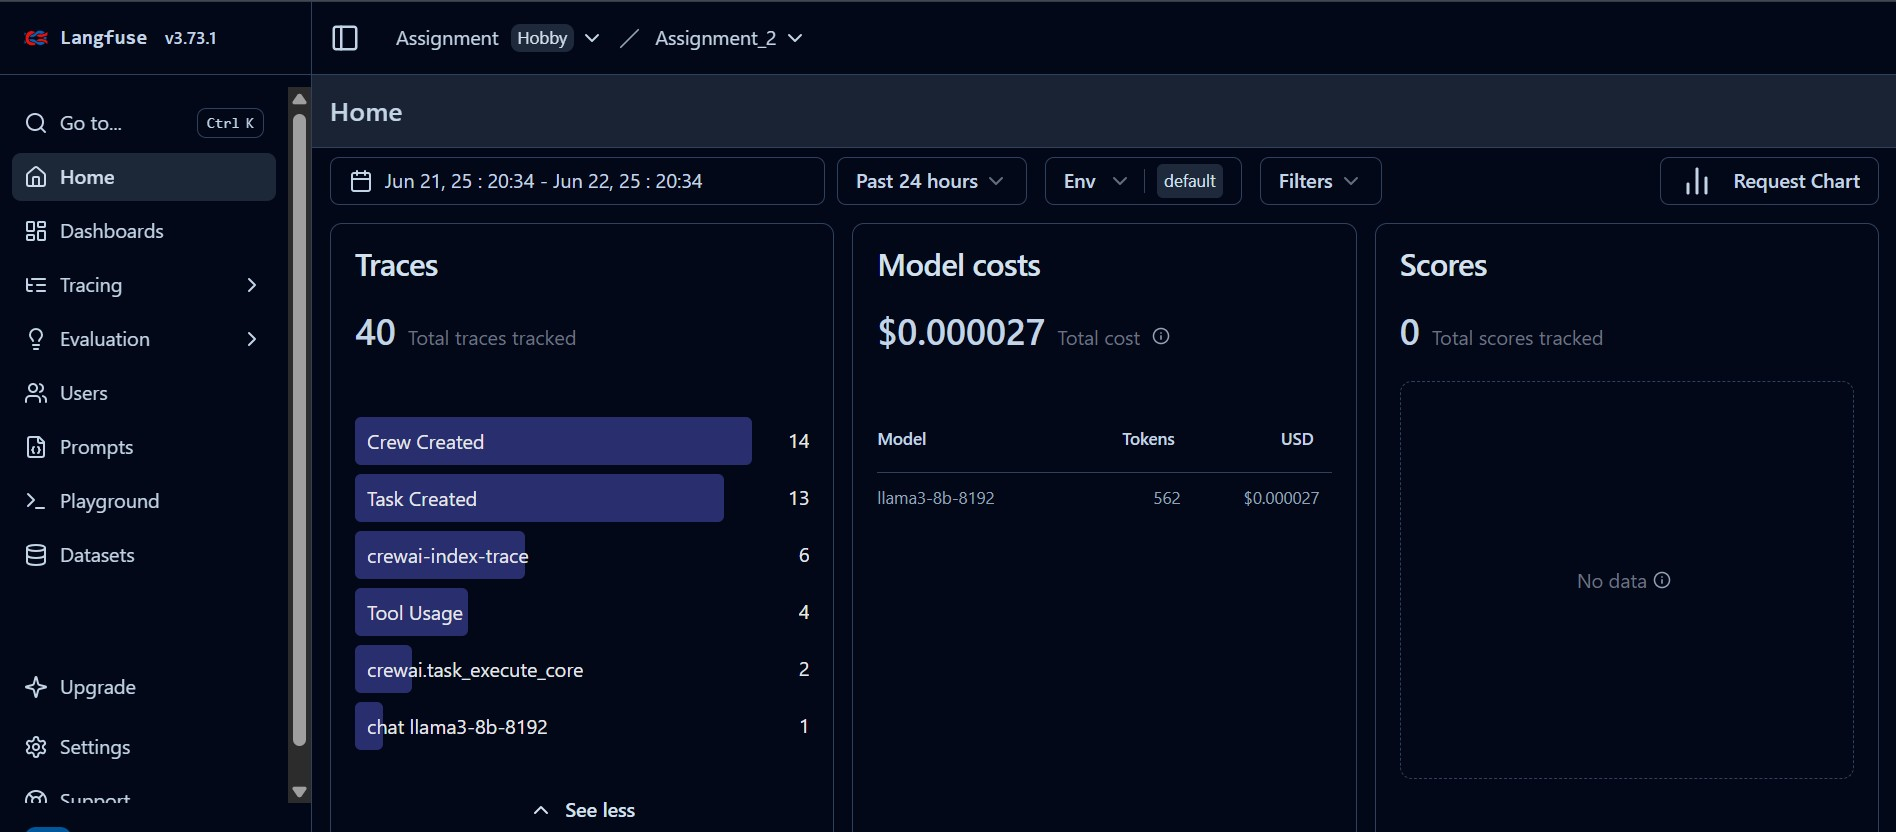

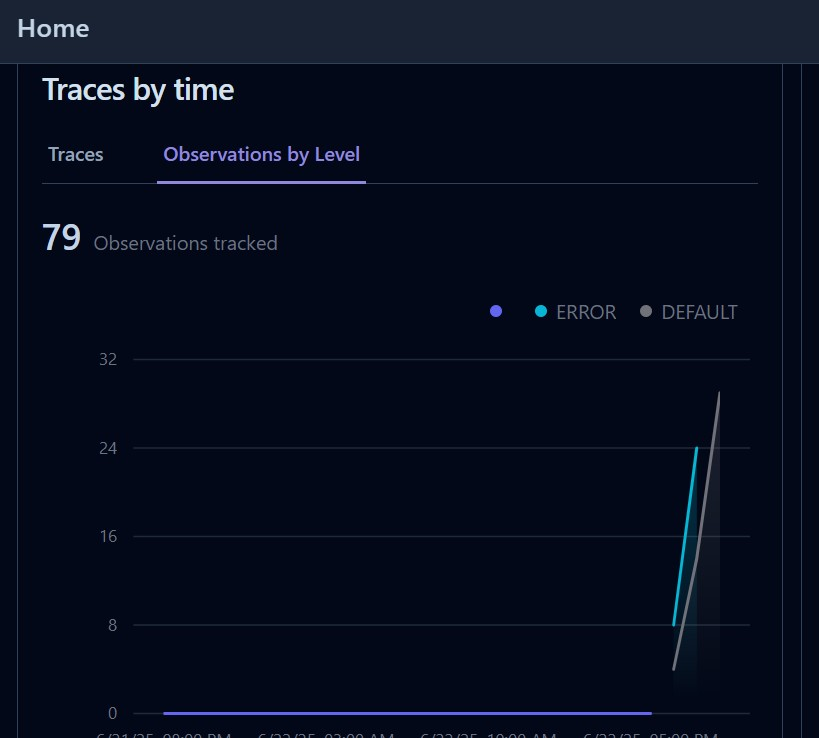

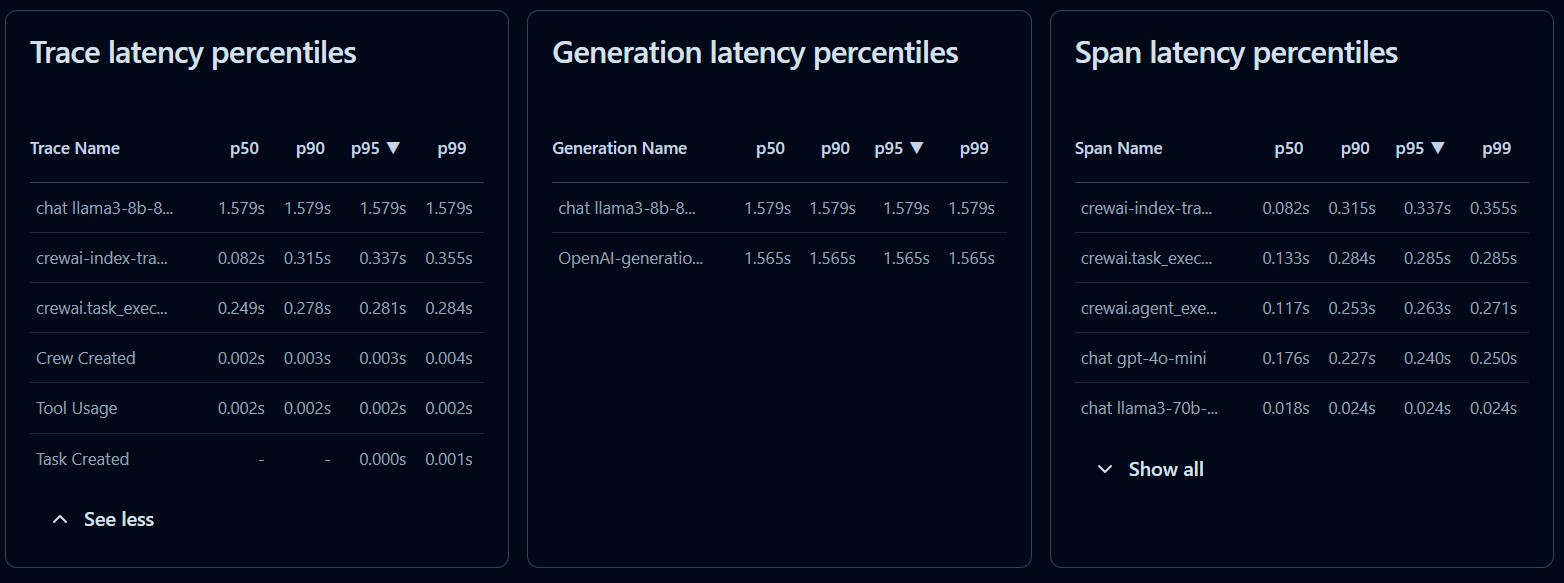

## Guidelines

- Do **not** use LangChain or LangSmith — this assignment is based on **CrewAI** and **Langfuse** only.
- Define 2–3 agents relevant to your chosen use case. Each agent should:
  - Have a clear role (e.g., Planner, Analyst, Writer)
  - Use a `run()` method or Task system to accomplish its goal
- Use **Langfuse** to trace each agent’s reasoning and outputs.

> Keep it simple — mock tools/APIs are acceptable.

## Deliverables

- Notebook link or Colab link
- Screenshots of Langfuse dashboards
- Clear comments or markdown cells explaining each agent's purpose and role